In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(tf.__version__)

2.1.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Receive Auto MPG dataset

398 samples with these attributes:



1.   mpg (miles per gallon):continuous
2.   cylinders: multi-valued discrete
3.   displacement: continuous
4.   horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string(unqiue for each instance)



In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [6]:
column_names = [ 'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Accerleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accerleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Data Preprocessing

Clean Data

In [7]:
dataset.isna().sum()

MPG              0
Cylinders        0
Displacement     0
Horsepower       6
Weight           0
Accerleration    0
Model Year       0
Origin           0
dtype: int64

In [0]:
dataset = dataset.dropna()

Convert Origin column from numerical to categorical

In [0]:
func = lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x)
dataset['Origin'] = dataset['Origin'].map(func)

In [10]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Accerleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Split into train and test set

In [0]:
train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)

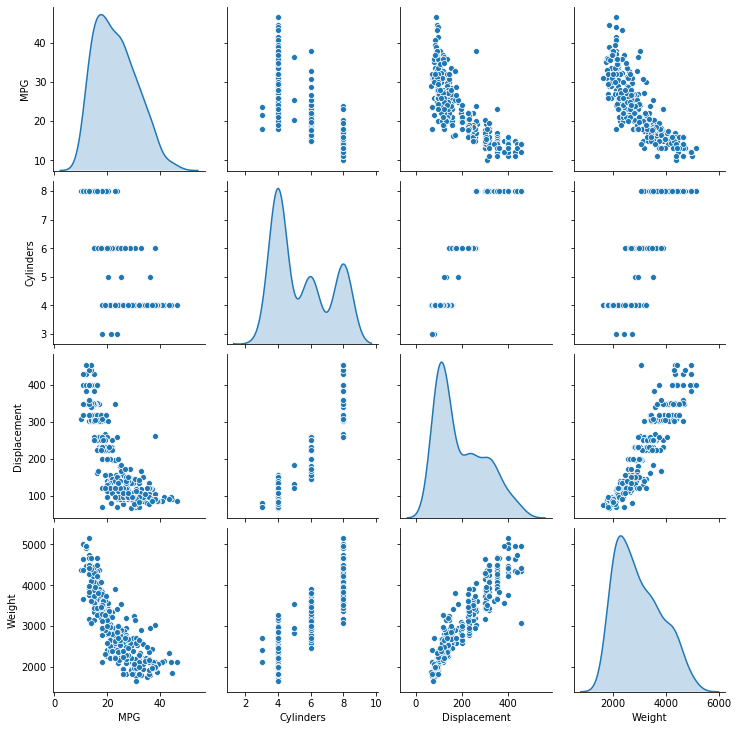

In [12]:
sns.pairplot(train_set[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [13]:
train_stats = train_set.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Accerleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [0]:
train_y = train_set.pop("MPG")
test_y = test_set.pop("MPG")

Normalize data

In [0]:
train_x = (train_set - train_stats['mean']) / train_stats['std']
test_x = (test_set - train_stats['mean']) / train_stats['std']

# Build the model

In [0]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[len(train_set.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  optimizer = keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

In [17]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [18]:
example_batch = train_x[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.233484  ],
       [ 0.01136791],
       [-0.02495722],
       [-0.01048609],
       [ 0.39259708],
       [-0.15815419],
       [ 0.44846714],
       [-0.13704336],
       [ 0.1281043 ],
       [ 0.5379411 ]], dtype=float32)

# Train model

In [19]:
EPOCHS = 1000
history = model.fit(
    train_x, train_y, epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:565.4478,  mae:22.5431,  mse:565.4478,  val_loss:559.7765,  val_mae:22.3965,  val_mse:559.7765,  
....................................................................................................
Epoch: 100, loss:6.0891,  mae:1.7493,  mse:6.0891,  val_loss:8.5051,  val_mae:2.1656,  val_mse:8.5051,  
....................................................................................................
Epoch: 200, loss:5.3960,  mae:1.5773,  mse:5.3960,  val_loss:8.8159,  val_mae:2.1798,  val_mse:8.8159,  
....................................................................................................
Epoch: 300, loss:4.6841,  mae:1.5073,  mse:4.6841,  val_loss:8.5715,  val_mae:2.2412,  val_mse:8.5715,  
....................................................................................................
Epoch: 400, loss:4.1663,  mae:1.3820,  mse:4.1663,  val_loss:9.2439,  val_mae:2.3210,  val_mse:9.2439,  
..............................................................

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.130775,0.943054,2.130775,9.202343,2.378383,9.202343,995
996,2.128129,0.959423,2.128129,9.605946,2.463515,9.605946,996
997,2.120910,0.931444,2.120910,9.740744,2.437793,9.740744,997
998,2.051650,0.917733,2.051649,9.623189,2.418078,9.623188,998
999,2.151196,0.932696,2.151196,9.723174,2.490635,9.723174,999


Text(0, 0.5, 'MAE [MPG]')

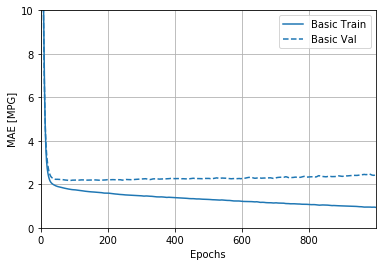

In [21]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = 'mae')
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

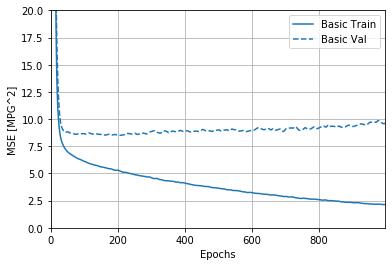

In [22]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

The validation error starts increasing again before reaching 200th's epoch. Early Stopping might help there

In [23]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_history = model.fit(train_x, train_y, epochs=EPOCHS, validation_split=0.2, verbose=0,
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:560.1994,  mae:22.4549,  mse:560.1995,  val_loss:545.3078,  val_mae:22.1108,  val_mse:545.3078,  
..................................................

Text(0, 0.5, 'MAE [MPG]')

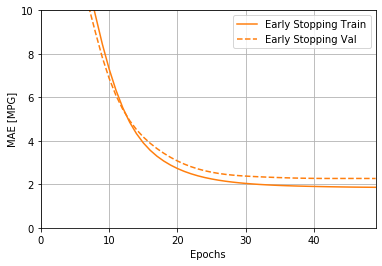

In [24]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

this looks better, the graph is constantly falling. converging at MAE= ~ 2 MPG

In [25]:
loss, mae, mse = model.evaluate(test_x, test_y, verbose=2)
print("MAE: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.0534 - mae: 1.9055 - mse: 6.0534
MAE:  1.91 MPG


## Predictions

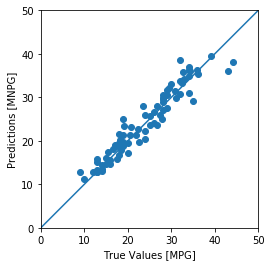

In [26]:
test_predictions = model.predict(test_x).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MNPG]')
lims = [0, 50]

plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Doesn't look bad

## Error distribution

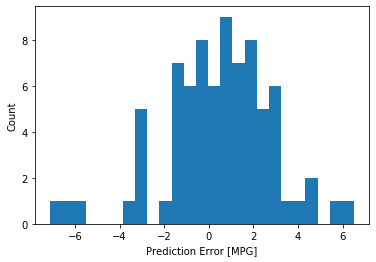

In [27]:
error = test_predictions - test_y
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

Looks almost gaussian!